In [1]:
# Data-handling libraries
import pandas as pd
import scipy.sparse

# Feature extraction/transformation libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.decomposition import PCA

# Modelling libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

from eda.accuracy import multiaccuracy, multiaccuracy_heatmap, fuzzy_accuracy
from sklearn.metrics import cohen_kappa_score

# Random seed
seed = 5777

# Import data

In [2]:
essays = pd.read_csv(f"../data_private/essays_cleaned.csv")

# Select/extract features

In [3]:
target_set = essays[(essays["essay_set"] == 3) | (essays["essay_set"] == 4)]

X = target_set.drop(columns=["score", "essay_id", "essay_set", "domain1_score", "rater1_domain1", "rater2_domain1"])
y = target_set["score"]

y.value_counts(normalize=True)

1.0    0.355549
2.0    0.350973
3.0    0.193364
0.0    0.100114
Name: score, dtype: float64

## Create train & test sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed);

In [5]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train.drop(columns="essay"))
X_test_sc = ss.transform(X_test.drop(columns="essay"))

pca = PCA(n_components=15)
Z_train = pca.fit_transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

## Vectorize text

In [6]:
cvec = CountVectorizer(
        ngram_range = (1,2),
        min_df = 2, # ignore hapaxes
    )

X_train_cvec = cvec.fit_transform(X_train["essay"]);
X_test_cvec = cvec.transform(X_test["essay"])

X_train_vectorized = np.concatenate([
    X_train.drop(columns="essay").values,
    X_train_cvec.todense()
], axis=1)

X_test_vectorized = np.concatenate([
    X_test.drop(columns="essay").values,
    X_test_cvec.todense()
], axis=1)

del X_train, X_test, X_train_cvec, X_test_cvec

## Scale data

In [7]:
ss = StandardScaler(with_mean=False)
X_train_sc = ss.fit_transform(X_train_vectorized)
X_test_sc = ss.transform(X_test_vectorized)

del X_train_vectorized, X_test_vectorized

# Fit models

In [8]:
%%time

lm = LinearRegression()
lm.fit(Z_train, y_train)

print("Train score:", lm.score(Z_train, y_train))
print("Test score:", lm.score(Z_test, y_test))

Train score: 0.551790928593054
Test score: 0.5254384553931242
CPU times: user 4.81 ms, sys: 10.9 ms, total: 15.7 ms
Wall time: 8 ms


In [19]:
def cohens_kappa(y_true, y_pred):
    """Calculates Cohen's kappa."""
    assert len(y_true) == len(y_pred), "Arrays must be the same length."

    cats = set(y_true) | set(y_pred)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    p_a = np.mean(y_true == y_pred)
    p_e = np.sum([np.mean(y_true == cat) *
                  np.mean(y_pred == cat)
                  for cat in cats])
    print([np.mean(y_true == cat)
                  for cat in cats])

    return (p_a - p_e) / (1 - p_e)



In [20]:
%%time

gnb = GaussianNB()
gnb.fit(Z_train, y_train)

print("Train score:", gnb.score(Z_train, y_train))
print("Test score:", gnb.score(Z_test, y_test))

# multiaccuracy_heatmap(y_test, gnb.predict(Z_test));
print(cohens_kappa(y_test, gnb.predict(Z_test)))
print(cohen_kappa_score(y_test, gnb.predict(Z_test)))

Train score: 0.589626239511823
Test score: 0.602974828375286
[0.08924485125858124, 0.36155606407322655, 0.32723112128146453, 0.2219679633867277]
0.4322933045809186
0.43229330458091864
CPU times: user 14.2 ms, sys: 0 ns, total: 14.2 ms
Wall time: 13.1 ms


In [ ]:
%%time

svm = SVC(random_state=seed)
svm.fit(X_train_sc, y_train)

print("Train score:", svm.score(X_train_sc, y_train))
print("Test score:", svm.score(X_test_sc, y_test))
multiaccuracy_heatmap(y_test, svm.predict(Z_test));

Train score: 0.5869565217391305
Test score: 0.5469107551487414
CPU times: user 572 ms, sys: 31 ms, total: 603 ms
Wall time: 500 ms


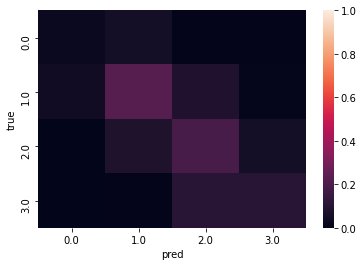

In [14]:
%%time

ada = AdaBoostClassifier()
ada.fit(Z_train, y_train)

print("Train score:", ada.score(Z_train, y_train))
print("Test score:", ada.score(Z_test, y_test))
multiaccuracy_heatmap(y_test, ada.predict(Z_test));

In [ ]:
%%time

# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(-5, -3, 10)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=5000)

# Fit model using best ridge alpha!
lasso_cv.fit(X_train_sc, y_train);

In [ ]:
print(lasso_cv.score(X_train_sc, y_train))
print(lasso_cv.score(X_test_sc, y_test))

In [ ]:
coefs = pd.DataFrame({
    "word": list(X.drop("essay", axis=1).columns) +
            cvec.get_feature_names(),
    "coef": lasso_cv.coef_
})
coefs = coefs[coefs["coef"] != 0]

# Evaluate models

In [ ]:
coefs.sort_values("coef", ascending=False).head(20)

In [ ]:
target_set[target_set["essay"].str.contains("hibiscus")]["essay"]